# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=cab1dfab15150235548ff6d08062b2a95a5ff9b3e71927eb7060d38b87efb35e
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=0c6769e109e7869e91f27daa2056859970a43a7506a8920667f3b1350a264d79
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.


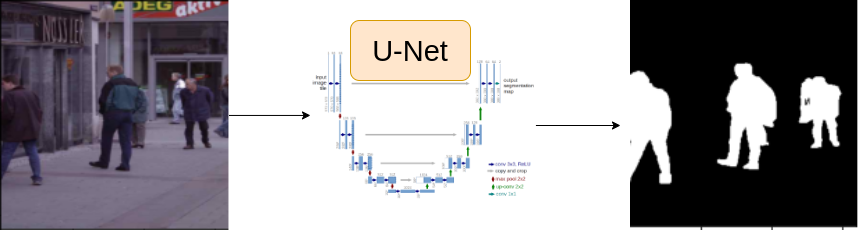

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

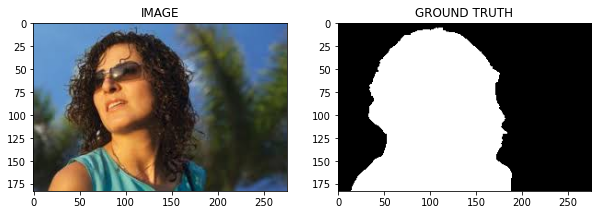

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))    
ax1.set_title('IMAGE')
ax1.imshow(image)
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
# split data
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),  # chance of flip
                    A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes = False)

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, index):
    row = self.df.iloc[index]
    
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # shape = (h, w)
    mask = np.expand_dims(mask, axis=-1)  # convert to shape = (h, w, c) w/ c=1

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # return as dictionary
      image = data.get('image')
      mask = data.get('mask')

    # shift (h, w, c) -> (c, h, w) since we use PyTorch
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # c:axis=2
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # convert to Tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)  # to 0 and 1 (we have 2 classes)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


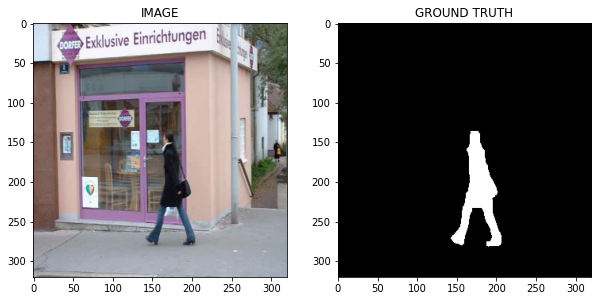

In [16]:
idx = 33
image, mask= trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')


One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
    super(SegmentationModel,self).__init__()
    self.architecture = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes=1,
        activation=None # output logits will be raw
    )

  def forward(self,images,masks=None):
      logits = self.architecture(images)
      if masks != None:
        loss1 = DiceLoss(mode='binary')(logits, masks)
        loss2 = nn.BCEWithLogitsLoss()(logits, masks)
        return logits, loss1 + loss2
      return logits



In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (architecture): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
  

# Task 7 : Create Train and Validation Function 

In [24]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(data_loader)

In [25]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  6.30it/s]


SAVED-MODEL
Epoch: 1 Train_loss: 0.812256133556366 Valid_loss: 1.7176163792610168


100%|██████████| 4/4 [00:00<00:00,  6.56it/s]


SAVED-MODEL
Epoch: 2 Train_loss: 0.38630592028299965 Valid_loss: 0.5681779161095619


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


SAVED-MODEL
Epoch: 3 Train_loss: 0.3172050346930822 Valid_loss: 0.25340724363923073


100%|██████████| 4/4 [00:00<00:00,  6.82it/s]


Epoch: 4 Train_loss: 0.2669994592666626 Valid_loss: 0.44452037662267685


100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Epoch: 5 Train_loss: 0.27153342465559643 Valid_loss: 0.2890852987766266


100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


SAVED-MODEL
Epoch: 6 Train_loss: 0.23445562819639842 Valid_loss: 0.23050538450479507


100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


Epoch: 7 Train_loss: 0.17418569326400757 Valid_loss: 0.3291897028684616


100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


Epoch: 8 Train_loss: 0.19247288902600607 Valid_loss: 0.23278413340449333


100%|██████████| 4/4 [00:00<00:00,  6.90it/s]


Epoch: 9 Train_loss: 0.16674892703692118 Valid_loss: 0.3601378910243511


100%|██████████| 4/4 [00:00<00:00,  6.97it/s]


Epoch: 10 Train_loss: 0.1744124303261439 Valid_loss: 0.2859053239226341


100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


SAVED-MODEL
Epoch: 11 Train_loss: 0.17670554518699647 Valid_loss: 0.1893011461943388


100%|██████████| 4/4 [00:00<00:00,  6.81it/s]


Epoch: 12 Train_loss: 0.17491242984930674 Valid_loss: 0.29112401977181435


100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


Epoch: 13 Train_loss: 0.19017378836870194 Valid_loss: 0.19630511850118637


100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


SAVED-MODEL
Epoch: 14 Train_loss: 0.17915662427743276 Valid_loss: 0.18417711928486824


100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


Epoch: 15 Train_loss: 0.1379449983437856 Valid_loss: 0.21421200037002563


100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


Epoch: 16 Train_loss: 0.14394799917936324 Valid_loss: 0.2556791454553604


100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


Epoch: 17 Train_loss: 0.15639366457859674 Valid_loss: 0.24387041106820107


100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


Epoch: 18 Train_loss: 0.16985052078962326 Valid_loss: 0.20667652413249016


100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Epoch: 19 Train_loss: 0.1512136623263359 Valid_loss: 0.21081960573792458


100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


SAVED-MODEL
Epoch: 20 Train_loss: 0.15010908593734104 Valid_loss: 0.17395991832017899


100%|██████████| 4/4 [00:00<00:00,  6.96it/s]


Epoch: 21 Train_loss: 0.1309989551703135 Valid_loss: 0.21620347537100315


100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


Epoch: 22 Train_loss: 0.1337894891699155 Valid_loss: 0.21877418458461761


100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


Epoch: 23 Train_loss: 0.11588097016016642 Valid_loss: 0.23018443956971169


100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


Epoch: 24 Train_loss: 0.1297572707136472 Valid_loss: 0.2000286616384983


100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

Epoch: 25 Train_loss: 0.10585158467292785 Valid_loss: 0.18578150868415833


# Task 9 : Inference

In [28]:
idx = 5
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze (0))  # (C, H, W) -> (1, C, H, W) where 1 is batch size just to use sigmoid
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

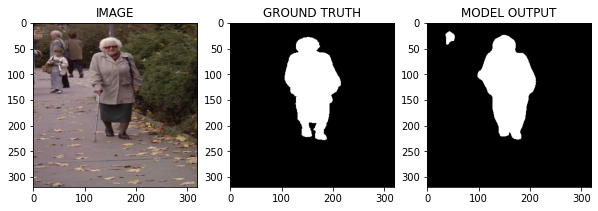

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # convert back (1, C, H, W) -> (C, H, W)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya